# TERA - Aula 30
## Redução de Dimensionalidade e Topic Analysis

Objetivos gerais de topic analysis:
- Agrupar dados de forma a criar representações sumarizadas (sumarização de dados)
- Redução de dimensionalidade
- Clusters encontrados são explicados (encontra tópicos)

# Índice

- [Exemplo inicial](#Exemplo-Inicial)
- [PCA](#Principal-Component-Analysis-(PCA)
- [T-SNE](#T-SNE)
- [Topic Analysis](#Topic-Analysis)
    - [NMF](#Non-Negative-Matrix-Factorization-(NMF)
    - [LDA](#Latent-Dirichlet-Allocation-(LDA)
- [Case Subcategorias Elo7](#Case-Elo7---Subcategorias-Automáticas)
- [Case Sistemas de Recomendação](#Case-Sistema-de-Recomendação)

In [1]:
# Imports usados no curso
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('seaborn-colorblind')

In [2]:
# Pasta contendo os dados:
ROOT_FOLDER = os.path.realpath('..')
DATASET_FOLDER = os.path.join(ROOT_FOLDER,'datasets')

---
# Exemplo inicial
- **Case Elo7: Clustering de Frete**

Vamos voltar para o problema de agrupamento de rotas para melhoria do frete no Elo7. Nosso vetor de atributos tem dimensão 4, o que nos impossibilita de observá-lo em apenas um gráfico. Essa limitação é um problema tanto do ponto de vista de intuição sobre o problema, quanto da correta observação dos resultados.

In [3]:
df_route = pd.read_csv(os.path.join(DATASET_FOLDER, 'route_clustering_elo7_dataset.csv'), sep=';')

df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


Para facilitar os cálculos de distância, as latitudes e longitudes dos locais já foram realizados.

Vamos observar a distribuição dos nossos dados. Como temos 4 dimensões, uma forma de fazer isso seria uma matriz de gráficos pareados.

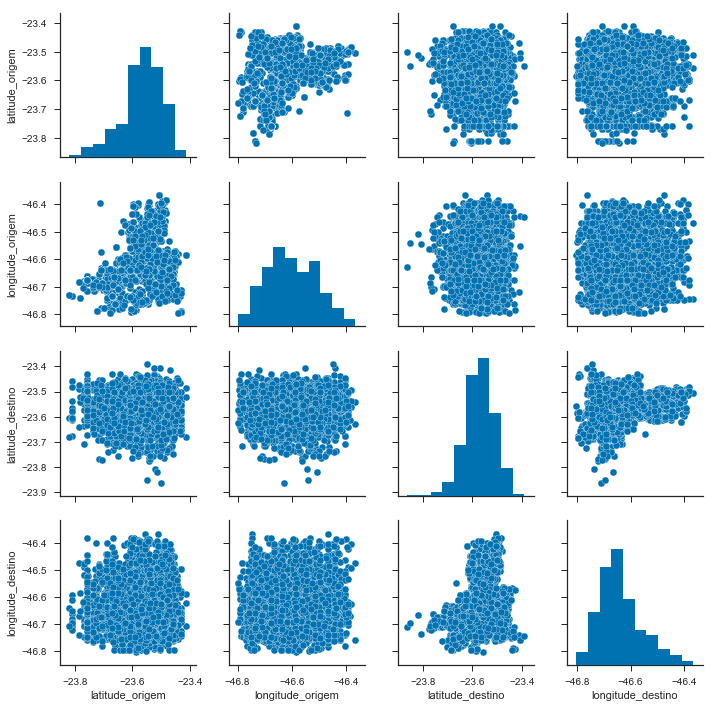

In [4]:
sns.pairplot(df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']])
plt.show()

Ok, 4 dimensões ainda é possível ter uma boa intuição sobre o problema. Mas, e mais do que 4?

### Exemplo 2
- **Variedades de grãos de trigo**

Vamos utilizar o dataset de diferentes tipos de grãos de trigo obtidos pelo [UCI](https://archive.ics.uci.edu/ml/datasets/seeds#).

<img src="https://kaggle2.blob.core.windows.net/datasets-images/904/1650/133a751e78dabf09031d6adfa0075ae0/dataset-original.jpg" width="400" height="100" />

Esse dataset contém medidas de raio-x de três variedades de grãos de trigo. Gostaríamos de 

O dataset contém os seguintes parâmetros:

- `area`: Área total do grão, A
- `perimeter`: Perímetro do grão, P
- `compactness`: Grão de compactação do grão - $C = \frac{4 \pi A}{P^2}$
- `length_kernel`: Comprimento do núcleo
- `width_kernel`: Largura do núcleo
- `asymmetry`: Coeficiente de assimetria
- `kernel_groove`: Comprimento do sulco do núcleo

Variedades de grãos: 'Kama' (1), 'Rosa' (2) e 'Canadian' (3)

Agora temos um dataset com 7 dimensões. As coisas estão ficando mais complicadas.

In [5]:
# Importar os dados
df_grain = pd.read_csv(os.path.join(DATASET_FOLDER, 'seeds_dataset.csv'), sep=';')
df_grain.head(5)

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry,kernel_groove,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama


Vamos aplicar agora a matriz de gráficos pareados para tentar visualizar o problema.

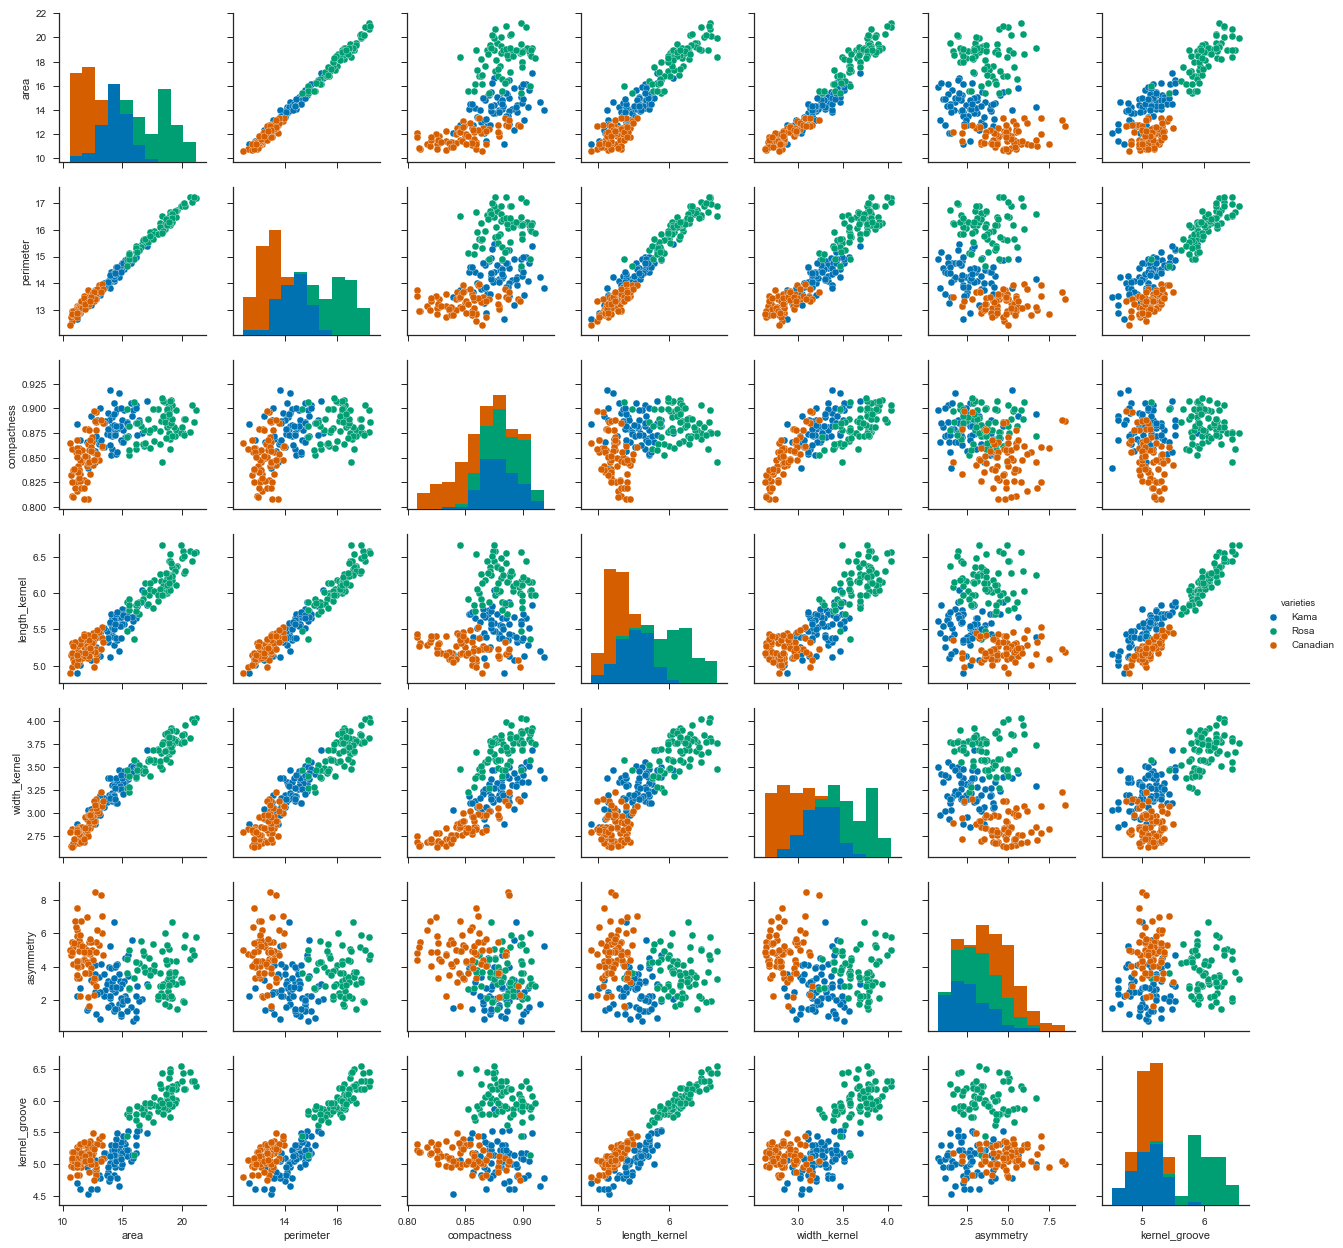

In [6]:
sns.pairplot(df_grain, hue='varieties')
plt.show()

Estamos agora sofrendo um pouco mais para visualizar os dados. O número de gráficos cresce ao quadrado em relação ao número de dimensões!

---
### Exemplo 3
- **Case Elo7 - Motivos de Compra**

Percebemos até agora que quanto maior o número de dimensões, menor nossa capacidade de observar e gerar intuição sobre o problema. O que podemos fazer agora com um problema de NLP, onde normalmente temos milhares de dimensões (cada palavra do vocabulário representa uma dimensão)?

Vamos verificar no dataset de motivos de compra dos usuários do Elo7.

In [7]:
df_reason = pd.read_csv(os.path.join(DATASET_FOLDER, 'purchase_reason_elo7_dataset.csv'), sep=';')

df_reason.head(10)

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento
5,caixa 40 charuto de chocolate belga,lembranca de maternidade
6,arquivo de corte vamos brindar,mimo para mim
7,prateleira com varao mdf reta 96x20x14,decoracao do quarto da minha filha
8,colherzinha bailarina,aniversario
9,caixa cone arvore jardim dos passarinhos,festa


Vamos utilizar o Tf-Idf para criar o embedding dos motivos de compra.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, max_features=500, sublinear_tf=True, use_idf=True)

Cria a matriz de embeddings.

In [9]:
X = tfidf.fit_transform(df_reason['reason'].values)

In [10]:
X.shape

(100000, 496)

Podemos observar que a matriz de atributos agora tem 496 dimensões! Para representar essas dimensões em uma matriz de gráficos pareados, nós precisaríamos de $496^2=246016$ gráficos! Totalmente impraticável!

Mas, a questão que deveria ser levantada é: Será que todas essas dimensões são necessárias para representar **fielmente** o problema? Será que não conseguiríamos simplificar de alguma forma? Isso é, não seria possível remover ou modificar certas dimensões que sejam "menos importantes" sem remover muita informação?
- Resposta: Sim, é possível!

---
# Principal Component Analysis (PCA)

O [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) é uma das técnicas mais utilizadas em Machine Learning para encontrar representações sumarizadas sobre os problemas de alta dimensionalidade. O PCA procura descorrelacionar linearmente os atributos do sistema, encontrando assim os **componentes principais**. Cada componente pode ser visto como um novo vetor de atributos que é formado pela combinação linear dos atributos originais. Os componentes principais são ordenados de forma que o primeiro componente representa a região de maior variância do sistema, o segundo representa a segunda maior e é ortogonal ao primeiro, e assim sucessivamente.

Vamos aplicar o método PCA nos problemas anteriores para verificar se conseguimos visualizar melhor o problema. Também podemos tentar reduzir o número de dimensões do nosso problema.

O algoritmo básico do PCA realiza 4 passos fundamentais para transformar o espaço de atributos e achar os componentes princiais:

1. Remove a média amostral
2. Rotaciona os eixos para descorrelacionar os dados
3. Ordena os componentes principais por nível de variância (importância)
4. Elimina os componentes menos variantes (Opcional - redução de dimensionalidade)

A implementação do PCA no sklearn pode ser encontrada neste [link](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

#### Elo7: Clustering Frete

In [11]:
df_route = pd.read_csv(os.path.join(DATASET_FOLDER, 'route_clustering_elo7_dataset.csv'), sep=';')

df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


In [12]:
from sklearn.preprocessing import StandardScaler

X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values

# Normaliza os dados
X_scaled = StandardScaler().fit_transform(X)

In [13]:
# Vamos agora importar o método PCA do scikit-learn
from sklearn.decomposition import PCA

# Criemos agora a instância PCA
# Não definimos o número de features: não realiza passo 4
pca = PCA()

In [14]:
X_pca = pca.fit_transform(X_scaled)

In [15]:
X_pca.shape

(4136, 4)

Observe que ainda temos 4 dimensões. O PCA não reduziu a dimensionalidade do problema. Esse passo pode ser realizado posteriormente. O que temos agora é uma relação de "importância" entre os componentes principais. Vamos plotar o gráfico com apenas os dois primeiros componentes para verificar o resultado.

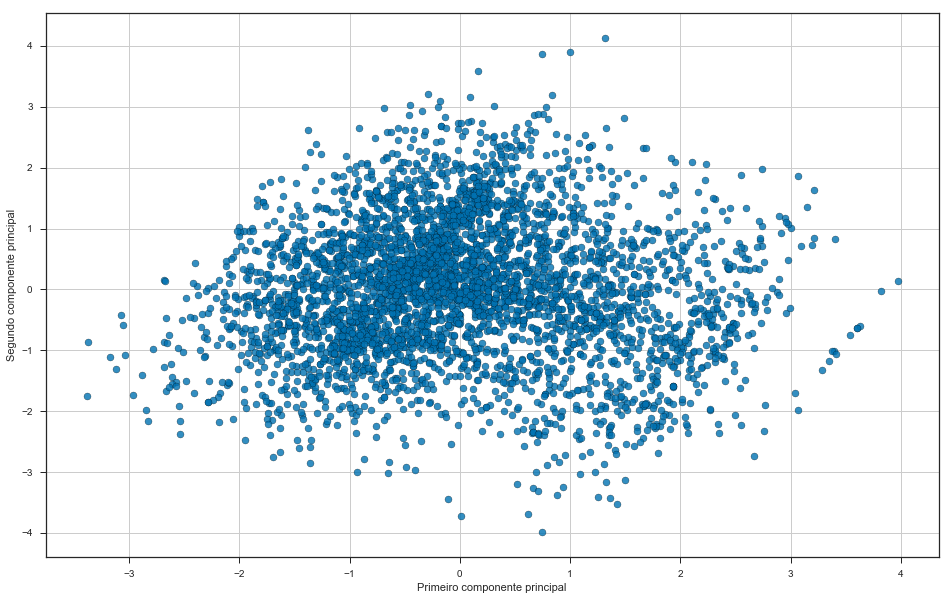

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

Vamos observar como ficariam os clusters encontrados na aula de Clustering.

In [17]:
# Encontra os clusters da aula anterior
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(X_scaled)

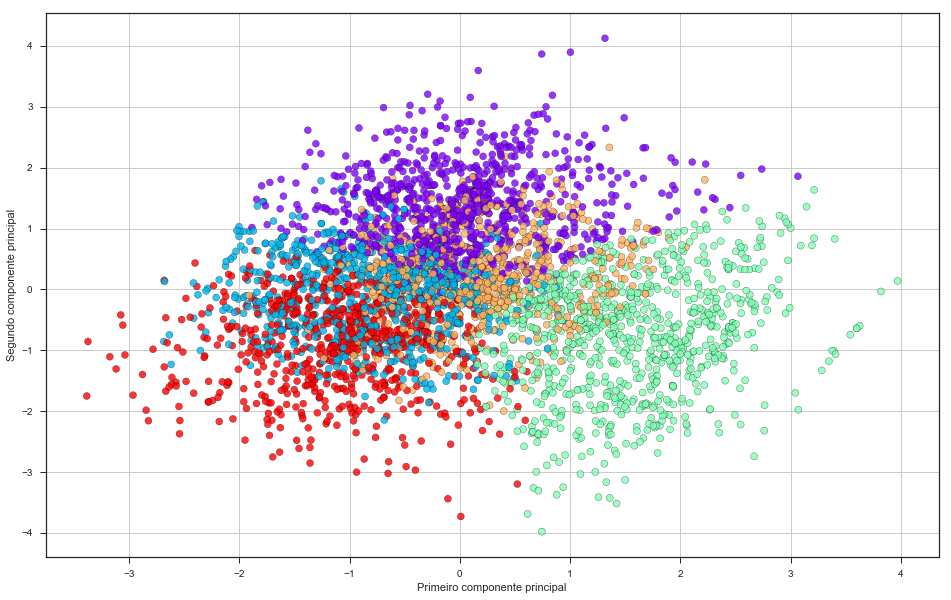

In [18]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

O que achou? Esses dois eixos nos mostram bons detalhes sobre os clusters encontrados anteriormente.

Outra coisa que podemos fazer é verificar o quanto cada eixo representa da variância do modelo, ou também chamado de **variância explicada** pelo componente.

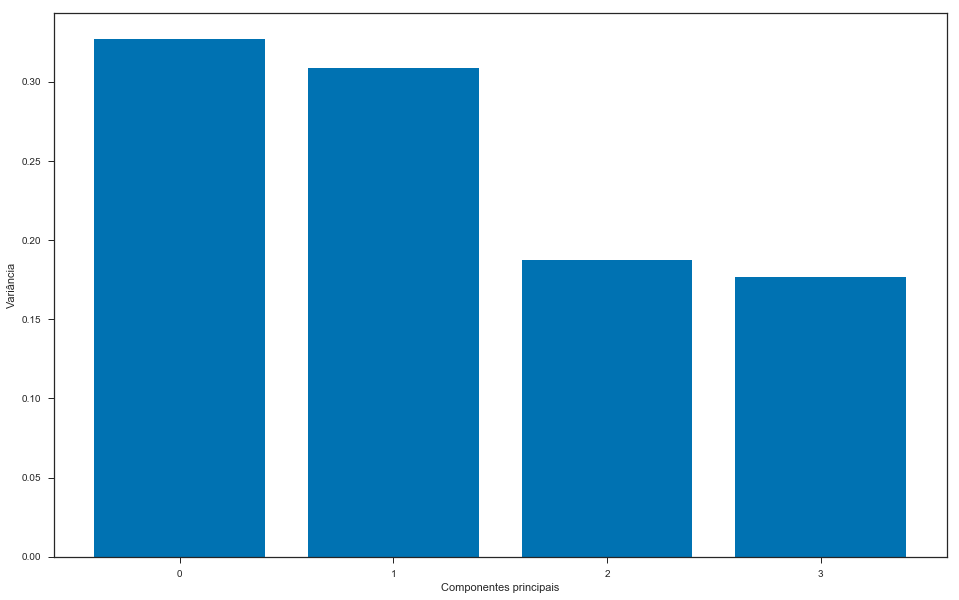

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 32.71%
2 Componente(s) principal(is): 63.59%
3 Componente(s) principal(is): 82.34%
4 Componente(s) principal(is): 100.00%


In [19]:
# Componentes principais
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

print('Variância explicada: ')
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

print('-'*50)
for i in range(len(pca.explained_variance_ratio_)):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Podemos perceber que os dois primeiros eixos em conjunto representam cerca de 63% da variância explicada. Isso ainda é pouco, mas já foi possível verificar uma boa representação dos dados. Outro fato a ser observado é que o quarto eixo não possui grande influência no sistema. Se retirássemos ele, ainda teríamos 3 eixos que explicariam 82% da variância do sistema. Se não estivermos preocupados com uma grande precisão, poderíamos retirar esse componente.

#### Variedade de grãos

Vamos praticar para um problema com mais dimensões.

In [20]:
# Importar os dados
df_grain = pd.read_csv(os.path.join(DATASET_FOLDER, 'seeds_dataset.csv'), sep=';')
df_grain.head(5)

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry,kernel_groove,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama


In [21]:
X = df_grain.drop('varieties',1).values

In [22]:
from sklearn.preprocessing import StandardScaler

# Normaliza os dados
normalizer = StandardScaler()
X_scaled = normalizer.fit_transform(X)

In [23]:
X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(210, 7)

In [24]:
# Transforma as labels em valores numéricos
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder().fit_transform(df_grain['varieties'].values)

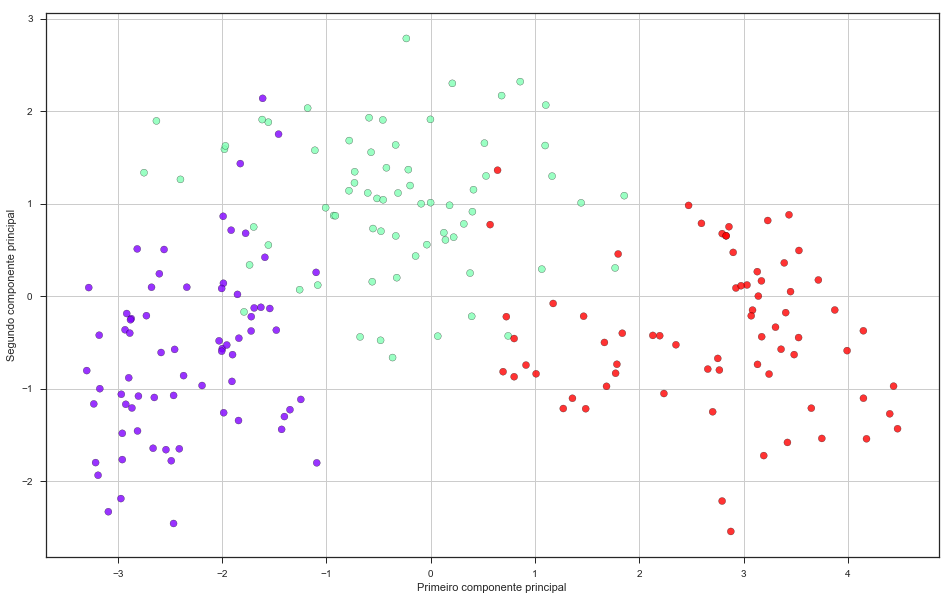

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

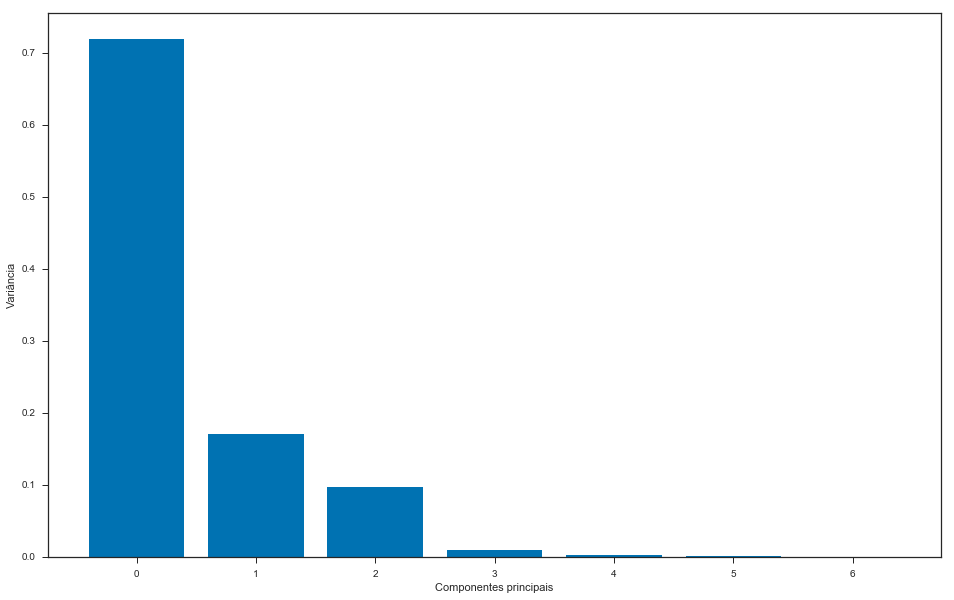

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 71.87%
2 Componente(s) principal(is): 88.98%
3 Componente(s) principal(is): 98.67%
4 Componente(s) principal(is): 99.64%
5 Componente(s) principal(is): 99.91%
6 Componente(s) principal(is): 99.99%
7 Componente(s) principal(is): 100.00%


In [26]:
# Componentes principais
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

print('Variância explicada: ')
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

print('-'*50)
for i in range(len(pca.explained_variance_ratio_)):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Utilizando apenas os 2 primeiros componentes, nós já podemos ter quase 90% da variância explicada. Isso significa que poderíamos reduzir de 7 para 2 dimensões sem perder muita informação! Isso é um grande avanço!

#### Elo7: Motivo de compra

In [27]:
df_reason = pd.read_csv(os.path.join(DATASET_FOLDER, 'purchase_reason_elo7_dataset.csv'), sep=';')

df_reason.head(10)

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento
5,caixa 40 charuto de chocolate belga,lembranca de maternidade
6,arquivo de corte vamos brindar,mimo para mim
7,prateleira com varao mdf reta 96x20x14,decoracao do quarto da minha filha
8,colherzinha bailarina,aniversario
9,caixa cone arvore jardim dos passarinhos,festa


In [28]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=500, sublinear_tf=True, use_idf=True)

In [29]:
X = tfidf.fit_transform(df_reason['reason'].values)

O TF-IDF cria uma representação esparsa para a matriz de atributos. Isso se deve ao fato de que existem muito mais "zeros" do que números na nossa matriz. Para isso, precisamos usar a função [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) do sklearn.

In [30]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X.shape[1]-1)

In [31]:
X_svd = svd.fit_transform(X)

Encontrar a variância explicada pelos componentes principais.

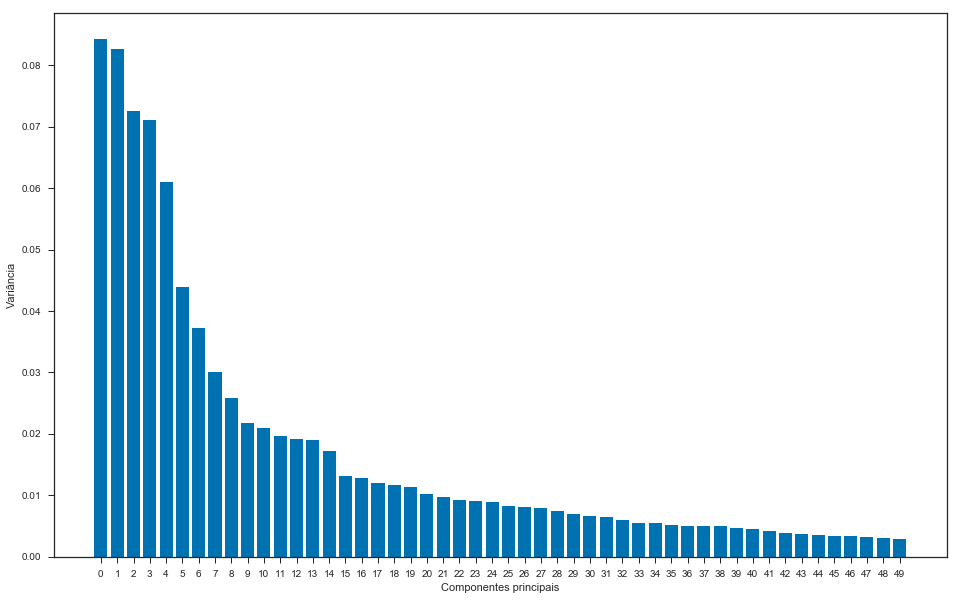

In [32]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [33]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var)[:100]

print('-'*50)
for i in range(0,len(exp_var[:100]),10):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 8.43%
11 Componente(s) principal(is): 55.14%
21 Componente(s) principal(is): 69.78%
31 Componente(s) principal(is): 78.00%
41 Componente(s) principal(is): 83.29%
51 Componente(s) principal(is): 86.70%
61 Componente(s) principal(is): 88.82%
71 Componente(s) principal(is): 90.32%
81 Componente(s) principal(is): 91.49%
91 Componente(s) principal(is): 92.49%


Podemos verificar que conseguiríamos reduzir consideravelmente a dimensão do problema! 

Vamos plotar o gráfico dos primeiros componentes.

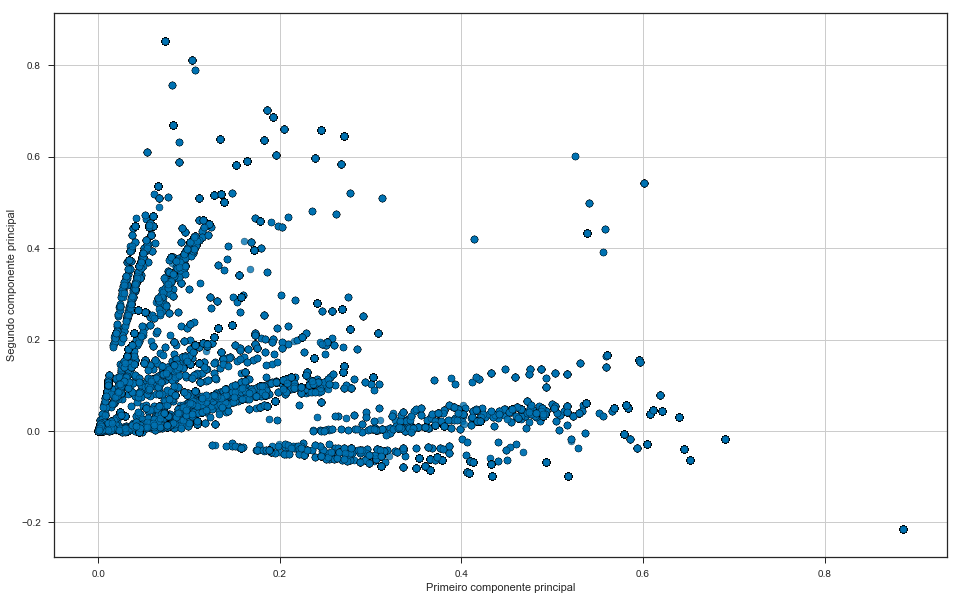

In [34]:
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

Podemos plotar também os centroides dos clusters encontrados utilizando o K-Means.

In [35]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(X)
labels = kmeans.predict(X)

# Cria um dataframe com as labels
df = pd.DataFrame({'reason': df_reason['reason'], 'labels': labels})

# Escolhe um título para o cluster
## para cada cluster, escolhe aleatoriamente um motivo de compra
titles = df.groupby('labels').apply(lambda x: np.random.choice(list(x['reason'])))

# Cria uma matriz representando os centroides dos clusters
X_centers_svd = svd.transform(kmeans.cluster_centers_)

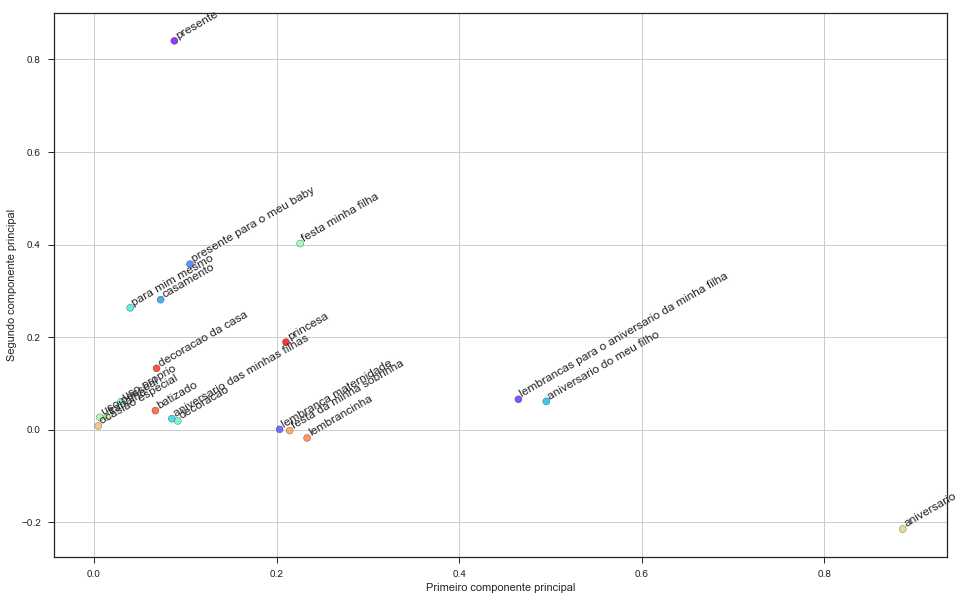

In [36]:
# plota os centroides dos clusters
plt.scatter(X_centers_svd[:, 0], X_centers_svd[:, 1], c=range(X_centers_svd.shape[0]), cmap='rainbow', alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()

# Coloca nomes nos pontos
for i, center in enumerate(kmeans.cluster_centers_):
    plt.annotate(titles[i], 
                 ((X_centers_svd[i, 0], X_centers_svd[i, 1])),
                 va="bottom", ha="left", rotation=30)
plt.show()

Agora estamos próximos do que gostaríamos! Em um gráfico já conseguimos ver mais informações sobre nossos dados de alta dimensionalidade!

---
# T-SNE

[T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) é um algoritmo de machine learning iterativo que procura mapear regiões multidimensionais em 2 ou 3 dimensões. O resultado gerado pelo método é um mapa de dispersão na qual os pontos com maior afinidade (mesma estrutura) estão próximos, enquanto os pontos dissimilares ficam distantes. Note que os eixos não têm necessariamente um significado predeterminado. Não podemos calcular distâncias entre pontos a partir do resultado do T-SNE.

Normalmente, o T-SNE é utilizado para visualização de dados. Podemos mapear problemas de alta dimensionalidade em 2 ou 3 dimensões, onde garantimos que a sua estrutura se manterá.

In [37]:
# Vamos agora importar o método T-SNE do scikit-learn
from sklearn.manifold import TSNE

#### Dataset variedade de grãos de trigo

In [38]:
X = df_grain.drop('varieties',1).values

X_scaled = normalizer.fit_transform(X)

# Codifica variedades em valores numéricos
label_encoder = LabelEncoder()
varieties = label_encoder.fit_transform(df_grain['varieties'].values)

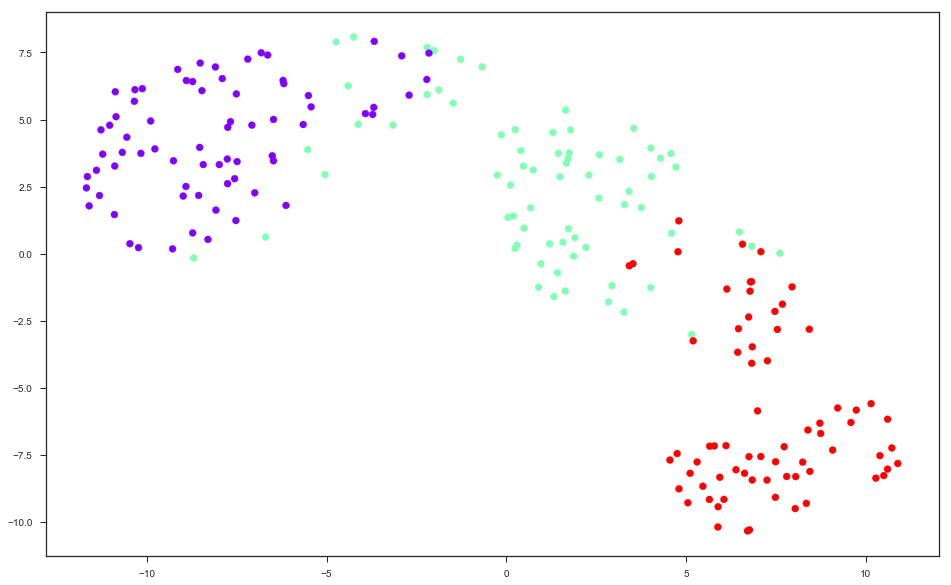

In [39]:
# Execute o T-SNE
# Crie a instância do T-SNE
# Teste diferentes valores de learning_rate e perplexity
tsne = TSNE(learning_rate=200, perplexity=30)

# Transforme os dados
X_tsne = tsne.fit_transform(X)

# Agora basta plotar o resultado
plt.scatter(X_tsne[:,0], 
            X_tsne[:,1], 
            c=varieties, 
            cmap='rainbow')
plt.show()

### Artigos do Wikipedia

O dataset que vamos utilizar foi retirado desse [link](https://blog.lateral.io/2015/06/the-unknown-perils-of-mining-wikipedia/). O dataset original contém 463 mil páginas do Wikipedia de diversos temas. Para não ficarmos o dia inteiro processando os dados, foram retirados apenas 58 artigos de classes bem definidas (por exemplo, futebol, música, internet etc). Vamos analisar o dataset:

In [40]:
df_wiki = pd.read_csv(os.path.join(DATASET_FOLDER, 'wikipedia_dataset.csv'), sep=';')

df_wiki.head()

,titulo,artigo,cluster
0,Black Sabbath,"Black Sabbath are an English rock band, formed...",Music
1,Lymphoma,Lymphoma is a type of blood cancer that occurs...,Sickness
2,Hepatitis C,Hepatitis C is an infectious disease affecting...,Sickness
3,HTTP cookie,"A cookie, also known as an HTTP cookie, web co...",Internet
4,Global warming,Global warming is the rise in the average temp...,Global_Warming


A coluna de clusters foi feita de maneira a facilitar nosso entendimento sobre o resultado final do algoritmo. Na maioria dos casos nós não teremos esse entendimento antes de realizar uma primeira análise (clustering) dos algoritmos.

Vamos tentar aplicar os métodos PCA para reduzir a dimensionalidade desse problema e o T-SNE para visualização.

Mas, primeiro, precisamos criar a matriz de atributos. Para isso, vamos utilizar o TF-IDF.

In [41]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=15000, sublinear_tf=True, use_idf=True)

In [42]:
# Aplique a transformação nos artigos
X = tfidf.fit_transform(df_wiki['artigo'].values)

# Tamanho do dataset
X.shape

(58, 15000)

Como temos 15000 dimensões, nós podemos ter problemas com a tal da *maldição da dimensionalidade*. Além disso, a probabilidade de cada uma das palavras estar dentro de todos os documentos é muito baixa. Ou seja, a matriz de atributos é muito esparsa. Isso nos dá um indício forte para acreditar que teremos grandes vantagens se utilizarmos uma técnica para reduzir a dimensionalidade, como o PCA.

In [43]:
# Vamos utilizar o TruncatedSVD para reduzir a dimensionalidade do dataset.
# Podemos limitar o número de components para ser igual ao número
# de dados: 58
# Desse modo temos uma matriz quadrada
svd = TruncatedSVD(n_components=58)

# Aplique o método SVD
X_svd = svd.fit_transform(X)

# Vamos ver como ficou o novo tamanho
X_svd.shape

(58, 58)

É uma redução bastante drástica! Reduzimos de 15000 dimensões para apenas 58. Será que perdemos muita informação? Vamos verificar o gráfico de variância explicada.

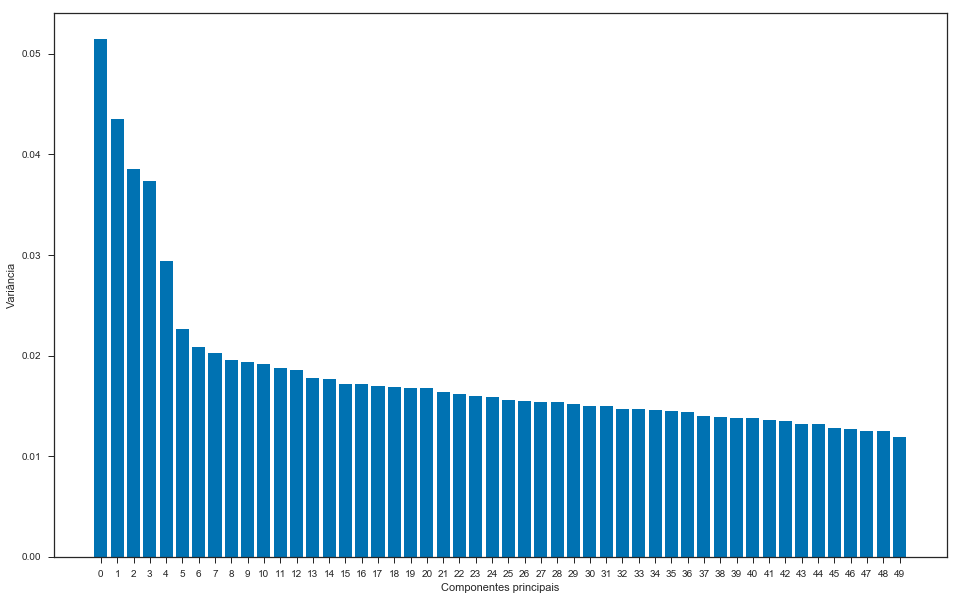

In [44]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [45]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var)

print('-'*50)
for i in range(0,len(exp_var),10):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 5.15%
11 Componente(s) principal(is): 32.22%
21 Componente(s) principal(is): 49.68%
31 Componente(s) principal(is): 65.32%
41 Componente(s) principal(is): 79.65%
51 Componente(s) principal(is): 92.41%


Podemos ver que ao utilizar 50 componentes, nós já teríamos aproximadamente 90% da variância explicada. Isso nos mostra que poderíamos reduzir ainda mais o número de dimensões escolhidas.

Vamos agora plotar o gráfico T-SNE para verificar a estrutura dos dados.

In [46]:
tsne = TSNE(learning_rate=5)

X_tsne = tsne.fit_transform(X_svd)

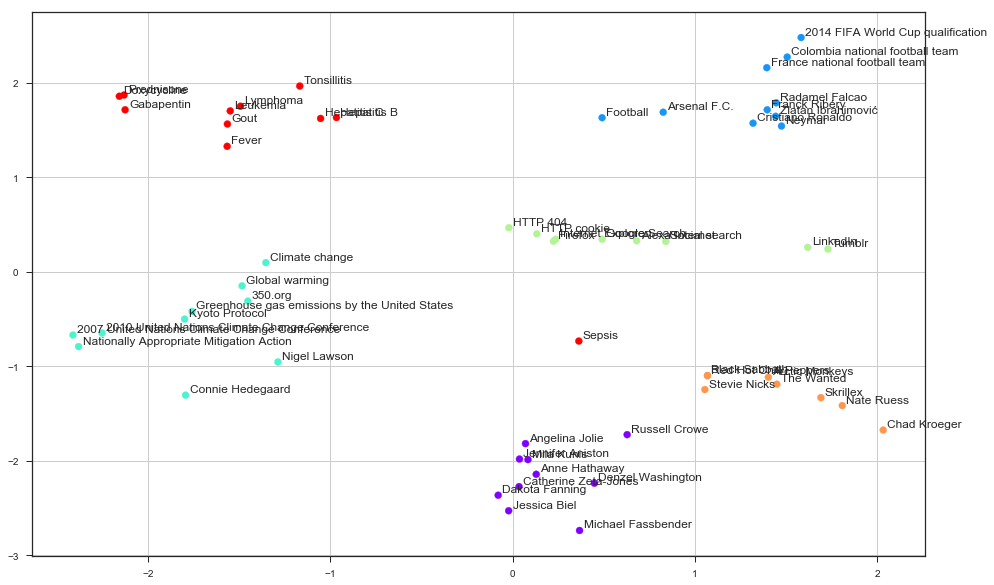

In [47]:
labels = LabelEncoder().fit_transform(df_wiki['cluster'].values)

plt.scatter(X_tsne[:, 0],
            X_tsne[:, 1],
            c=labels,
            cmap='rainbow')

for i in range(X_tsne.shape[0]):
    # Anota os motivos no gráfico
    plt.annotate(df_wiki['titulo'][i], 
                 ((X_tsne[i, 0], X_tsne[i, 1])),
                 xytext=(4, 3), 
                 textcoords='offset points')
plt.grid()
plt.show()

Nós conseguímos apresentar dados de 15000 dimensões em apenas duas e, ainda assim, verificar a presença de uma estrutura bem definida entre os clusters. Incrível, não?

### Case Elo7: Motivos de compra

Agora tente aplicar os métodos PCA e T-SNE para encontrar relações entre os dados. Utilize as ferramentas apresentadas anteriormente para gerar um bom entendimento sobre o problema.

In [48]:
X = tfidf.fit_transform(df_reason['reason'].values)

Aplique os métodos PCA e T-SNE.

In [49]:
# Execute o PCA (TruncatedSVD)
# Encontre uma região de corte para reduzir a dimensionalidade
svd = TruncatedSVD(n_components=X.shape[1]-1)

# Aplique o método SVD
X_svd = svd.fit_transform(X)

# Vamos ver como ficou o novo tamanho
X_svd.shape

(100000, 495)

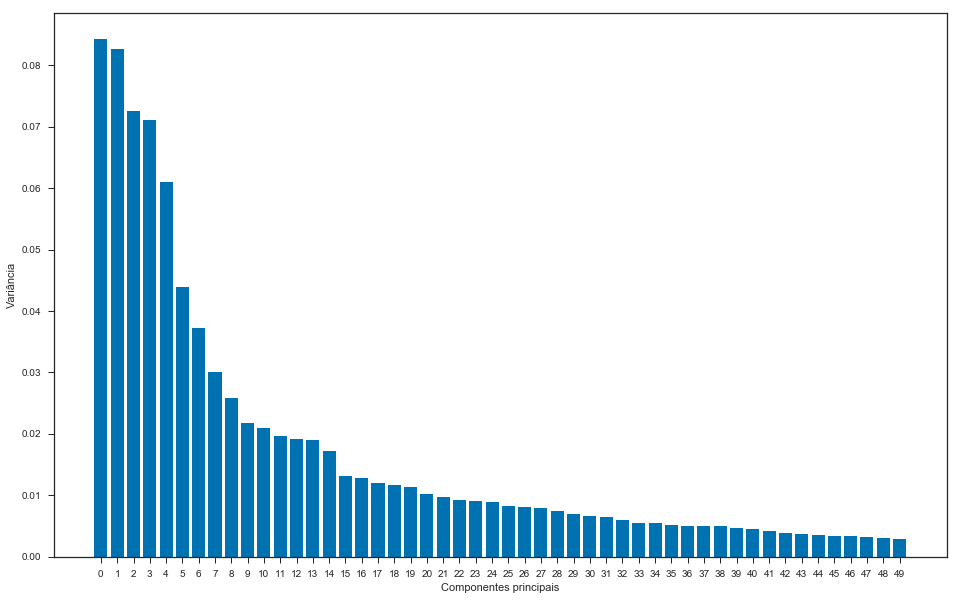

In [50]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [51]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var[:100])

print('-'*50)
for i in range(0,len(exp_var[:100]),10):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 8.43%
11 Componente(s) principal(is): 55.14%
21 Componente(s) principal(is): 69.78%
31 Componente(s) principal(is): 78.00%
41 Componente(s) principal(is): 83.29%
51 Componente(s) principal(is): 86.70%
61 Componente(s) principal(is): 88.82%
71 Componente(s) principal(is): 90.32%
81 Componente(s) principal(is): 91.49%
91 Componente(s) principal(is): 92.49%


Podemos perceber que poderíamos facilmente utilizar apenas 70 dimensões. Isso já nos daria uma variância explicada de aproximadamente 90%.

In [52]:
svd = TruncatedSVD(n_components=70)

# Aplique o método SVD no sample dos dados
df_sample = df_reason.sample(n=75)
X_sample = tfidf.transform(df_sample['reason'].values)

X_svd = svd.fit_transform(X_sample)

In [53]:
# Execute o T-SNE
# Crie a instância do T-SNE
# Teste diferentes valores de learning_rate e perplexity
tsne = TSNE(learning_rate=5)

X_tsne = tsne.fit_transform(X_svd)

Como fizemos para o PCA (ou TruncatedSVD), podemos plotar os clusters obtidos pelo K-Means.

In [54]:
# Apenas para auxiliar a verificação dos clusters
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_svd)
labels = kmeans.predict(X_svd)

# Cria um dataframe com as labels
df = pd.DataFrame({'reason': df_sample['reason'], 'labels': labels})

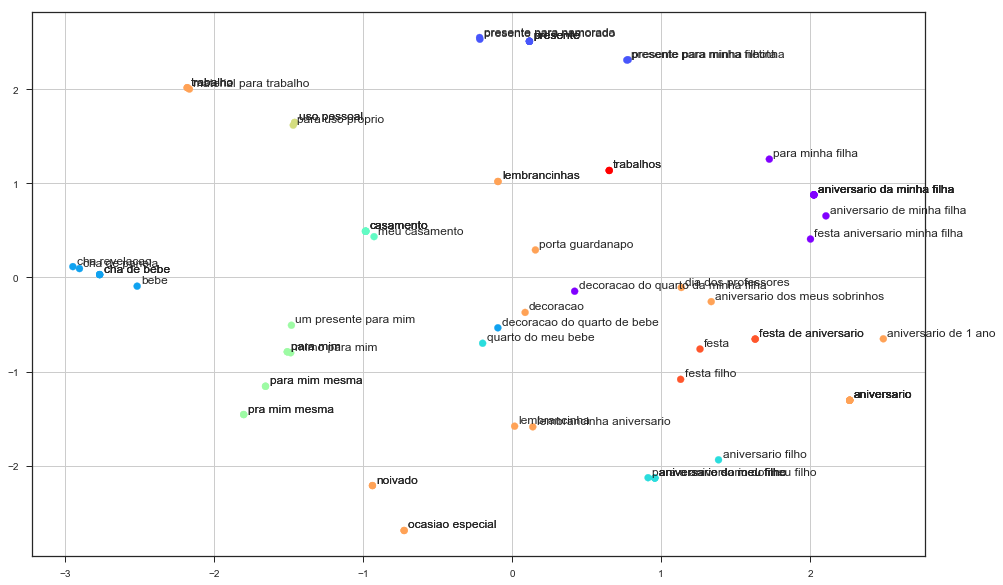

In [55]:
# Apresenta o resultado do T-SNE de duas dimensões com as cores
# indicando cada um dos clusters pré-definidos
labels_sample = df['labels'].values
titles_sample = df['reason'].values

plt.scatter(X_tsne[:, 0],
            X_tsne[:, 1],
            c=labels_sample,
            cmap='rainbow')

for i in range(X_tsne.shape[0]):
    # Anota os motivos no gráfico
    plt.annotate(titles_sample[i][:100], 
                 ((X_tsne[i, 0], X_tsne[i, 1])),
                 xytext=(4, 3), 
                 textcoords='offset points')
plt.grid()
plt.show()

# Topic Analysis

Até agora, nós utilizamos diversos algoritmos de clustering e redução de dimensionalidade para conseguir encontrar relações de proximidade entre documentos. Entretanto, apesar de algoritmos como o PCA conseguirem representar reduzidamente o nosso conjunto de documentos, nós não conseguíamos interpretar o resultado obtido. Isso acontece porque o PCA encontra novos vetores de features que são combinações lineares do conjunto de palavras existentes. Esse fator pode não ser um problema se o que se deseja é apenas encontrar clusters sem interpretações mais profundas. Entretanto, muitas vezes gostaríamos de entender o racional por trás da geração dos clusters. Ainda mais, as vezes gostaríamos de reduzir um documento a um conjunto de palavras-chave que podem "resumir" o nosso documento e agrupá-las em **tópicos**. E é exatamente esse o objetivo dessa aula.

A área de topic analysis é de grande importância para Machine Learning, ou mais especificamente a área de Data Mining. A utilização de tópicos nos permite ter uma melhor e mais compacta representação dos nossos dados, principalmente quando temos um conjunto extenso de dados e atributos (features). 

Utilizar topic analysis em Natural Language Processing (NLP) é algo bem intuitivo. Nós naturalmente fazemos isso quando queremos organizar textos (documentos) em diferentes categorias, ou temas. Por exemplo, nós podemos ler artigos do Google News e dizer facilmente que um determinado artigo tem o tema "esporte", ou o tema "política". Nosso trabalho em topic analysis é o de conseguir desenvolver algoritmos de Machine Learning que possam encontrar automaticamente esses tópicos, ou temas, por nós.

## Non-Negative Matrix Factorization (NMF)

O [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) é um algoritmo poderoso (apesar de relativamente simples) para encontrar tópicos em um conjunto de documentos e features. Ele se baseia em um processo de decomposição de matrizes para criar uma representação adequada da matriz de frequência de palavras (denotado por **A**). Mais especificamente, o NMF decompõe a matriz de frequência de palavras em duas: a primeira é a matriz de pesos (chamada de **W**), com as linhas representando os documentos e as colunas indicando os tópicos; e a segunda é a matriz de atributos (chamada de **H**), com as linhas indicando os tópicos e as colunas os atributos. O número de tópicos é definido antecipadamente e é fixo.

<img src="./imagens/nmf_draw.png" alt="Drawing" style="width: 500px;"/>

As duas matrizes são formadas a partir de um processo iterativo de otimização (veja esse [link](http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf) para mais detalhes) com o objetivo de reconstruir fielmente a matriz **A**. Entretanto, para esse fim, a matriz **A** não pode possuir entradas negativas.

Vamos aplicar esse método na prática para verificar o resultado!

### Exemplo Wikipedia

In [56]:
df_wiki = pd.read_csv(os.path.join(DATASET_FOLDER, 'wikipedia_dataset.csv'), sep=';')

df_wiki.head()

,titulo,artigo,cluster
0,Black Sabbath,"Black Sabbath are an English rock band, formed...",Music
1,Lymphoma,Lymphoma is a type of blood cancer that occurs...,Sickness
2,Hepatitis C,Hepatitis C is an infectious disease affecting...,Sickness
3,HTTP cookie,"A cookie, also known as an HTTP cookie, web co...",Internet
4,Global warming,Global warming is the rise in the average temp...,Global_Warming


In [57]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=15000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_wiki['artigo'].values)

In [58]:
# Primeiro, importe o módulo NMF do scikit-learn
from sklearn.decomposition import NMF

# Precisamos criar a instância do NMF
# Temos que definir um número de componentes para o NMF
# Como temos 6 clusters, vamos escolher n_components=6
nmf = NMF(n_components=6)

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
W_nmf = nmf.fit_transform(X)

# Vamos ver qual é a dimensão de W_nmf
W_nmf.shape

(58, 6)

Note que o número de linhas se manteve em 58, que é o número de documentos (artigos) que nós temos, e o número de colunas se transformou em 6, que é o número de tópicos que nós escolhemos. Essa matriz gerada representa a matriz **W** (matriz de pesos) da fatoração de matrizes.

Vamos agora achar a matriz **H** que representa a matriz de atributos.

In [59]:
H_nmf = nmf.components_
H_nmf.shape

(6, 15000)

Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Cada linha da matriz é definida como um componente (assim como o PCA possui os componentes principais) que está associado a um tópico específico. Entretanto, diferentemente do PCA, nós podemos associar cada componente a um conjunto específico de palavras. Vamos verificar abaixo:

In [60]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tfidf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(nmf.components_, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(6):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest(10))
    print("----------")

Topico 0:
----------
film       0.229179
she        0.215746
starred    0.190031
her        0.186223
award      0.161489
actress    0.151807
role       0.150151
actor      0.144102
drama      0.134155
cast       0.130585
Name: 0, dtype: float64
----------
Topico 1:
----------
treatment    0.162181
disease      0.138491
symptoms     0.133928
infection    0.130257
blood        0.120941
cell         0.113213
patients     0.107489
chronic      0.102847
cause        0.099488
acute        0.098793
Name: 1, dtype: float64
----------
Topico 2:
----------
cup         0.131918
scored      0.126456
fifa        0.117084
goals       0.113224
team        0.108496
goal        0.108391
match       0.105999
football    0.105558
uefa        0.102144
matches     0.097230
Name: 2, dtype: float64
----------
Topico 3:
----------
climate       0.229707
emissions     0.189543
conference    0.131644
greenhouse    0.126121
change        0.121209
global        0.116665
gas           0.116026
kyoto         0.1141

O que achou da distribuição de palavras dentro de cada tópico? Acha que faz sentido com os temas principais dos artigos do Wikipedia? Cada um dos tópicos poderia ser associado a um cluster?

Podemos ainda verificar quais são os tópicos principais de alguns artigos específicos.

In [61]:
# Precisamos criar um dataframe para facilitar nossa vida
df = pd.DataFrame(W_nmf, index=df_wiki['titulo'])

examples = ['Denzel Washington','Leukemia','Neymar','LinkedIn','Arctic Monkeys','Global warming']

for ex in examples:
    print('Artigo: {}'.format(ex))
    print('-'*30)
    print('Topico\tDist.\tPalavras')
    print('-'*30)
    for i,topic in enumerate(df.loc[ex]):
        words = components_df.iloc[i].nlargest(5).index.tolist()
        print('{}\t{:.2f}\t{}'.format(i,topic,', '.join(words)))
    print()

Artigo: Denzel Washington
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.31	film, she, starred, her, award
1	0.00	treatment, disease, symptoms, infection, blood
2	0.02	cup, scored, fifa, goals, team
3	0.00	climate, emissions, conference, greenhouse, change
4	0.00	users, web, search, google, user
5	0.00	album, band, song, tour, songs

Artigo: Leukemia
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.01	film, she, starred, her, award
1	0.50	treatment, disease, symptoms, infection, blood
2	0.00	cup, scored, fifa, goals, team
3	0.00	climate, emissions, conference, greenhouse, change
4	0.00	users, web, search, google, user
5	0.00	album, band, song, tour, songs

Artigo: Neymar
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.02	film, she, starred, her, award
1	0.00	treatment, disease, symptoms, infection, blood
2	0.51	cup, scored, fifa, goals, team
3	0.00	climate, emissions,

Podemos notar que os artigos possuem tópicos coerentes com o que esperávamos!

Vamos agrupar agora os artigos pelos tópicos principais de cada um deles e ver como eles tém relação com os clusters definidos anteriormente.

In [62]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(W_nmf, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'article': df_wiki['titulo']})

# Apresenta os resultados
print(df.sort_values(by='label'))

                                          article  label
10                                   Jessica Biel      0
19                                 Angelina Jolie      0
18                                     Mila Kunis      0
38                                  Anne Hathaway      0
5                            Catherine Zeta-Jones      0
46                             Michael Fassbender      0
7                               Denzel Washington      0
50                               Jennifer Aniston      0
25                                 Dakota Fanning      0
12                                  Russell Crowe      0
49                                    Tonsillitis      1
31                                       Leukemia      1
24                                          Fever      1
52                                     Prednisone      1
9                                            Gout      1
8                                     Hepatitis B      1
34                             

Só por diversão, vamos verificar como ficaria um agrupamento usando Hierarchical Clustering na matriz de atributos obtida pelo NMF.

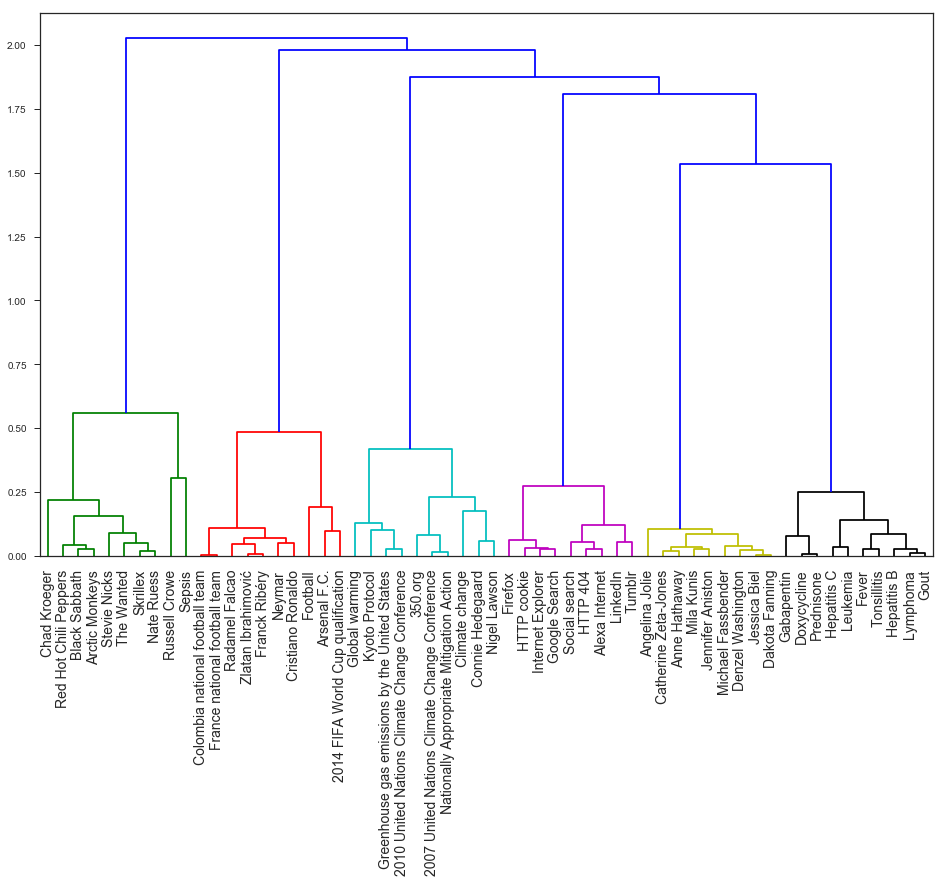

In [63]:
from scipy.cluster.hierarchy import linkage, dendrogram

Y = linkage(W_nmf, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_wiki['titulo'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

O que achou do resultado? Percebeu que o NMF não só encontrou uma representação em tópicos dos documentos, mas também teve um papel de agregador? Ele realizou um ótimo trabalho em encontrar clusters! E o melhor, nós podemos explicar com palavras o que representa cada um dos tópicos/clusters.

### Case Elo7: Motivos de Compra

Agora aplique o NMF no dataset de motivos de compra e verifique o resultado comparado ao PCA.

In [64]:
df_reason.head()

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento


In [65]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=5000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_reason['reason'].values)

In [66]:
nmf = NMF(n_components=20)

# Aplique o método SVD
W_nmf = nmf.fit_transform(X)

# Vamos ver como ficou o novo tamanho
W_nmf.shape

(100000, 20)

In [67]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tfidf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(nmf.components_, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(W_nmf.shape[1]):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest(10))
    print("----------")

Topico 0:
----------
aniversario      12.530450
da                0.140119
ano               0.070469
infantil          0.060512
filhos            0.051726
dos               0.036775
meus              0.030062
lembranca         0.028891
lembrancinhas     0.027762
sobrinha          0.027352
Name: 0, dtype: float64
----------
Topico 1:
----------
presente     10.671227
amiga         0.117961
um            0.117089
natal         0.103643
principe      0.094999
sobrinha      0.084605
padrinhos     0.061403
uma           0.056301
filha         0.056258
pra           0.054643
Name: 1, dtype: float64
----------
Topico 2:
----------
casamento        9.663051
convite          0.192688
padrinhos        0.079059
convites         0.061377
lembrancas       0.020893
meu              0.016339
madrinhas        0.015956
nosso            0.013103
lembranca        0.011499
lembrancinhas    0.005855
Name: 2, dtype: float64
----------
Topico 3:
----------
filha         6.998989
minha         5.414849
da   

In [68]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(W_nmf, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'reason': df_reason['reason']})

# Pega um sample
df_sample = df.sample(n=60)

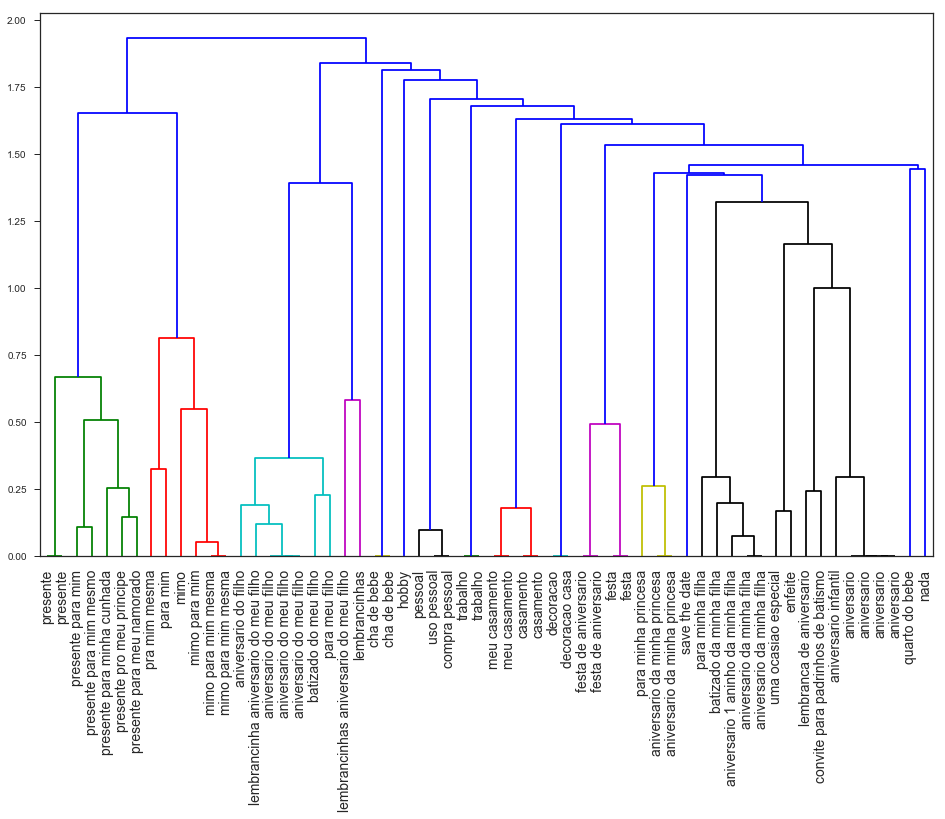

In [69]:
X_sample = df_sample['reason'].values

W_nmf = nmf.fit_transform(tfidf.fit_transform(X_sample))

Y = linkage(W_nmf, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_sample['reason'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

## Latent Dirichlet Allocation (LDA)

Assim como o NMF, o [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) é um algoritmo relativamente simples (pelo menos algoritmicamente) e poderoso para conseguir encontrar tópicos dentro de documentos. Entretanto, diferentemente do NMF, o LDA se baseia em métodos probabilísticos. Mais especificamente, o **LDA** assume que cada **documento** foi gerado a partir de uma **mistura de tópicos** com uma distribuição de probabilidade (no caso, uma distribuição [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution)), e cada **tópico** foi gerado por uma distribuição de **palavras** com certa probabilidade associada (distribuição [multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution)).

Para imaginar um cenário, imagine que temos os seguintes documentos (retirados deste [link](https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation)):
1. I ate a banana and spinach smoothie for breakfast
2. I like to eat broccoli and bananas.
3. Chinchillas and kittens are cute.
4. My sister adopted a kitten yesterday.
5. Look at this cute hamster munching on a piece of broccoli.

Para o LDA, os documentos poderiam ser formados pelos seguintes tópicos e palavras:
- Documentos 1 e 2: 100% Tópico A
- Documentos 3 e 4: 100% Tópico B
- Documento 5: 60% Tópico A, 40% Tópico B

- Tópico A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching (Talvez represente algo relacionado a comida)
- Tópico B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster (Talvez seja relacionado a animais fofinhos)

Esse comportamento do LDA é interessante, já que temos uma representação mais intuitiva da formação dos documentos. Poderíamos até criar documentos artificiais a partir dessas definições.

Agora vamos ver um exemplo de aplicação utilizando o dataset do Wikipedia.

In [70]:
df_wiki = pd.read_csv(os.path.join(DATASET_FOLDER, 'wikipedia_dataset.csv'), sep=';')

df_wiki.head()

,titulo,artigo,cluster
0,Black Sabbath,"Black Sabbath are an English rock band, formed...",Music
1,Lymphoma,Lymphoma is a type of blood cancer that occurs...,Sickness
2,Hepatitis C,Hepatitis C is an infectious disease affecting...,Sickness
3,HTTP cookie,"A cookie, also known as an HTTP cookie, web co...",Internet
4,Global warming,Global warming is the rise in the average temp...,Global_Warming


O LDA não pode ser utilizado com Tf-Idf, porque ele precisa da contagem total de palavras nos documentos. Por esse motivo, vamos utilizar o método [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) do scikit-learn. Esse método apenas realiza a contagem de frequência de palavras nos documentos. Para evitar que "stopwords" tenham uma importância indevida, podemos remove-las do texto.

In [71]:
# Importa o módulo CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.95, min_df=0.01, max_features=15000, stop_words='english')

X = tf.fit_transform(df_wiki['artigo'].values)

In [72]:
# Agora vamos importar o módulo LDA do scikit-learn
from sklearn.decomposition import LatentDirichletAllocation

# Precisamos criar a instância do LDA
# Temos que definir um número de tópicos do LDA
# Como temos 6 clusters, vamos escolher n_topics=6
lda = LatentDirichletAllocation(n_topics=6, learning_method='batch')

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
X_lda = lda.fit_transform(X)

# Vamos ver qual é a dimensão de X_lda
X_lda.shape

(58, 6)

Note que o número de linhas se manteve em 58, que é o número de documentos (artigos) que nós temos, e o número de colunas se transformou em 6, que é o número de tópicos que nós escolhemos. 

Vamos agora achar a matriz de atributos.

In [73]:
# Normaliza os componentes
lda_components = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(lda_components.shape)

(6, 15000)


Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Essa matriz é semelhante a matriz de atributos do NMF.

Vamos achar quais são as palavras mais importantes para cada tópico.

In [74]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(lda_components, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(6):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest())
    print("----------")

Topico 0:
----------
football    0.019543
cookies     0.014094
cookie      0.011621
user        0.008996
ball        0.008391
Name: 0, dtype: float64
----------
Topico 1:
----------
internet    0.015208
explorer    0.013433
search      0.010553
google      0.010074
firefox     0.009598
Name: 1, dtype: float64
----------
Topico 2:
----------
jolie    0.008261
film     0.008043
iron     0.004993
award    0.003997
album    0.003464
Name: 2, dtype: float64
----------
Topico 3:
----------
band        0.016847
album       0.012852
released    0.006610
nicks       0.006287
tour        0.006079
Name: 3, dtype: float64
----------
Topico 4:
----------
climate      0.011315
emissions    0.009818
global       0.006729
change       0.006467
countries    0.005189
Name: 4, dtype: float64
----------
Topico 5:
----------
ronaldo    0.010845
goal       0.010364
scored     0.010020
team       0.009332
league     0.008715
Name: 5, dtype: float64
----------


O que achou da distribuição de palavras dentro de cada tópico? Acha que faz sentido com os temas principais dos artigos do Wikipedia? Cada um dos tópicos poderia ser associado a um cluster?

Podemos ainda verificar quais são os tópicos principais de alguns artigos específicos.

In [75]:
# Precisamos criar um dataframe para facilitar nossa vida
df = pd.DataFrame(X_lda, index=df_wiki['titulo'])

examples = ['Denzel Washington','Leukemia','Neymar','LinkedIn','Arctic Monkeys','Global warming']

for ex in examples:
    print('Artigo: {}'.format(ex))
    print('-'*30)
    print('Topico\tDist.\tPalavras')
    print('-'*30)
    for i,topic in enumerate(df.loc[ex]):
        words = components_df.iloc[i].nlargest(5).index.tolist()
        print('{}\t{:.2f}\t{}'.format(i,topic,', '.join(words)))
    print()

Artigo: Denzel Washington
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.00	football, cookies, cookie, user, ball
1	0.00	internet, explorer, search, google, firefox
2	0.99	jolie, film, iron, award, album
3	0.00	band, album, released, nicks, tour
4	0.00	climate, emissions, global, change, countries
5	0.00	ronaldo, goal, scored, team, league

Artigo: Leukemia
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.00	football, cookies, cookie, user, ball
1	0.00	internet, explorer, search, google, firefox
2	0.00	jolie, film, iron, award, album
3	0.00	band, album, released, nicks, tour
4	1.00	climate, emissions, global, change, countries
5	0.00	ronaldo, goal, scored, team, league

Artigo: Neymar
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.00	football, cookies, cookie, user, ball
1	0.00	internet, explorer, search, google, firefox
2	0.00	jolie, film, iron, award, album
3	0.00	

In [76]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(X_lda, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'titulo': df_wiki['titulo']})

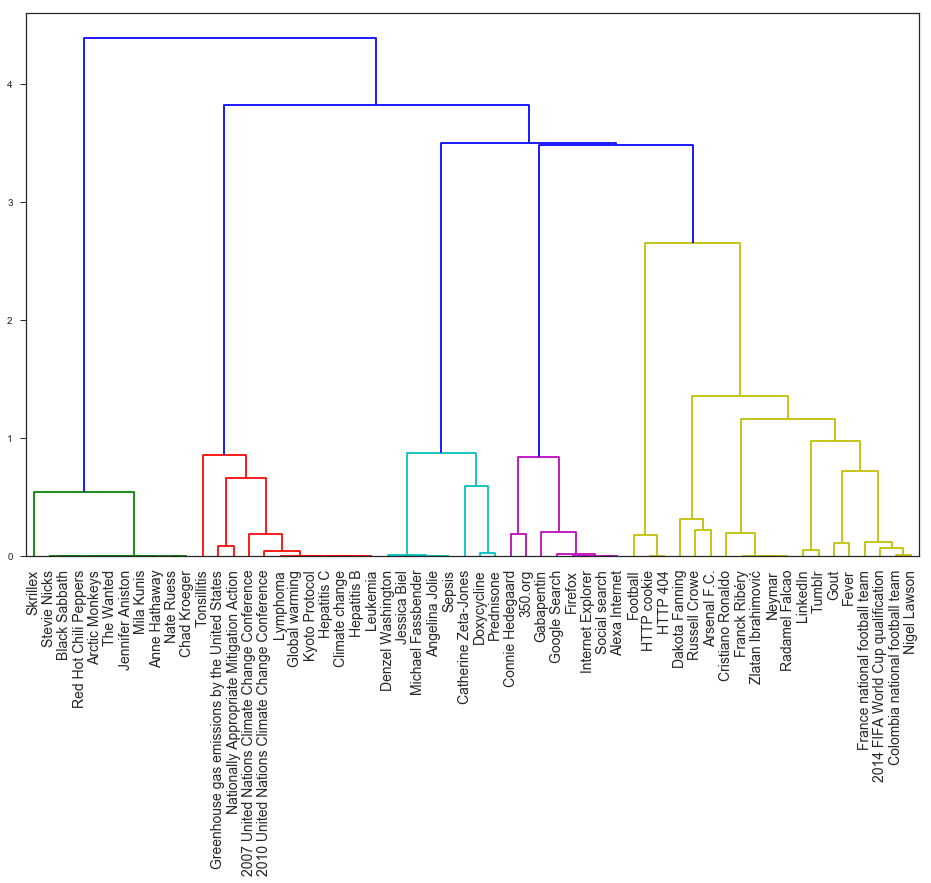

In [77]:
Y = linkage(X_lda, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_wiki['titulo'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

---
# Case Elo7 - Subcategorias Automáticas

Vamos para mais um case real do Elo7!

Esse case é um dos trabalhos mais recentes do time de Data Science do Elo7. De fato, é um trabalho ainda em aberto e qualquer sugestão de melhorias é bem vinda! =)

- O problema:
O Elo7 possui uma árvore de categorias dividida em N1 e N2. O primeiro nível (N1) contém as categorias "alto nível" do site. São as categorias mais genéricas do marketplace- ou, pelo menos, é assim gostaríamos que fosse. As categorias N2, ou subcategorias, são as possíveis extensões dos nós das categorias N1. Podemos perceber que a árvore é extremamente limitada e isso é um problema grave não só para os compradores, que não conseguem navegar nas nossas categorias, mas também para os vendedores, que não conseguem categorizar bem seus produtos. A solução para esse problema seria uma árvore de categorias com maior "granularidade", ou seja, que consiga expandir além dos 2 níveis e ter mais subcategorias.

- O que o time de Data Science tem a ver com essa história? 

Bom, gerar uma nova árvore de categoria pode ser uma tarefa bastante monótona e cansativa. Provavelmente deve haver algum jeito de encontrar bons agrupamentos de produtos que pudessem servir como uma nova subcategoria. Talvez algum método de clustering que utilize como features o conteúdo dos produtos pode gerar algum resultado interessante.

- O experimento:

O dataset a seguir possui um subconjunto de produtos que foram categorizados na categoria N1 "Casamento". Escolhemos esse conjunto de dados para iniciar nossos trabalhos, porque assim temos mais controle sobre nossos resultados. E, também, porque é uma das categorias mais importantes do marketplace.

Para essa tarefa, vamos utilizar apenas o título e uma parte da descrição do produto (aprox. 140 caracteres) como features de entrada.

Vamos analisar os dados!

In [78]:
df_cat = pd.read_csv(os.path.join(DATASET_FOLDER, 'subcategory_elo7_dataset.csv'), sep=';')

df_cat.head(10)

,title,short_description,url
0,terco love ii niquel,vc quiser simular clique produto informe cep e...,https://www.elo7.com.br/jfndgm/dp/36CBDF
1,porta joias rustico,porta joias mdf presentear madrinhas lembranca...,https://www.elo7.com.br/jfndgm/dp/65FE78
2,convite casamento lisboa,compra minima 50 unidades convite casamento 15...,https://www.elo7.com.br/jfndgm/dp/2557F0
3,daminhas 82 00 cada,tecido cristal voal fino,https://www.elo7.com.br/jfndgm/dp/4D60B6
4,aromatizador,aromatizador ambientes varetas frasco vidro cu...,https://www.elo7.com.br/jfndgm/dp/5FECD3
5,chinelo casamento personalizado noivos,personalizamos qualquer tema foto precos difer...,https://www.elo7.com.br/jfndgm/dp/6B06A4
6,monograma brasao casamento modelo 91,monograma brasao casamento iniciais descricao ...,https://www.elo7.com.br/jfndgm/dp/B04210
7,caixa lembrancinhas papel,caixa cartonagem revestida papel detalhe fita ...,https://www.elo7.com.br/jfndgm/dp/28DF6F
8,body noiva personalizada,body personalizado madrinhas usarem despedida ...,https://www.elo7.com.br/jfndgm/dp/AAE311
9,quadro casamento mario geek nerd,ideal presente peca decoracao quadro eterniza ...,https://www.elo7.com.br/jfndgm/dp/8939E7


Vamos criar uma coluna com as features que vamos incluir no nosso modelo de aprendizagem.
Esse vetor de features será o título + descrição do produto. Para compensar a quantidade de palavras do título em relação a descrição, vamos repetir o título duas vezes.

In [79]:
df_cat['title_desc'] = (df_cat['title'] + ' ')*2 + df_cat['short_description']

df_cat.head(10)

,title,short_description,url,title_desc
0,terco love ii niquel,vc quiser simular clique produto informe cep e...,https://www.elo7.com.br/jfndgm/dp/36CBDF,terco love ii niquel terco love ii niquel vc q...
1,porta joias rustico,porta joias mdf presentear madrinhas lembranca...,https://www.elo7.com.br/jfndgm/dp/65FE78,porta joias rustico porta joias rustico porta ...
2,convite casamento lisboa,compra minima 50 unidades convite casamento 15...,https://www.elo7.com.br/jfndgm/dp/2557F0,convite casamento lisboa convite casamento lis...
3,daminhas 82 00 cada,tecido cristal voal fino,https://www.elo7.com.br/jfndgm/dp/4D60B6,daminhas 82 00 cada daminhas 82 00 cada tecido...
4,aromatizador,aromatizador ambientes varetas frasco vidro cu...,https://www.elo7.com.br/jfndgm/dp/5FECD3,aromatizador aromatizador aromatizador ambient...
5,chinelo casamento personalizado noivos,personalizamos qualquer tema foto precos difer...,https://www.elo7.com.br/jfndgm/dp/6B06A4,chinelo casamento personalizado noivos chinelo...
6,monograma brasao casamento modelo 91,monograma brasao casamento iniciais descricao ...,https://www.elo7.com.br/jfndgm/dp/B04210,monograma brasao casamento modelo 91 monograma...
7,caixa lembrancinhas papel,caixa cartonagem revestida papel detalhe fita ...,https://www.elo7.com.br/jfndgm/dp/28DF6F,caixa lembrancinhas papel caixa lembrancinhas ...
8,body noiva personalizada,body personalizado madrinhas usarem despedida ...,https://www.elo7.com.br/jfndgm/dp/AAE311,body noiva personalizada body noiva personaliz...
9,quadro casamento mario geek nerd,ideal presente peca decoracao quadro eterniza ...,https://www.elo7.com.br/jfndgm/dp/8939E7,quadro casamento mario geek nerd quadro casame...


Para criar nossa matriz de features, nós vamos utilizar o Tf-Idf.

In [80]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=10000, sublinear_tf=True, use_idf=True)

In [81]:
X = tfidf.fit_transform(df_cat['title_desc'].values)

Agora aplique os métodos encontrados até agora para tentar encontrar uma boa árvore de categorias.

In [82]:
# TODO

---
# Case Sistema de Recomendação

Esse case foi retirado desse [artigo](https://towardsdatascience.com/topic-modeling-for-the-new-york-times-news-dataset-1f643e15caac). O objetivo dele é verificar se conseguimos extrair tópicos relevantes de um dataset contendo 8.447 matérias do NY Times, com um vocabulário de 3.012 palavras. Por razão de direitos autorias, os documentos não possuem título.

<img src="https://cdn-images-1.medium.com/max/1400/1*toWf7lAVf_5GIb9IMfS8Bw.jpeg" alt="Drawing" style="width: 800px;"/>


O arquivo `nyt_dataset.csv` contém os documentos, onde cada linha representa um documento específico e cada coluna representa a frequência de cada palavra. O dataset já sofreu um processo de limpeza e vetorização, onde foram mantidas apenas palavras que ocorreram mais de 10 vezes.

Vamos criar a matriz de frequências a partir desses dados:

In [83]:
df_nyt = pd.read_csv(os.path.join(DATASET_FOLDER, 'nyt_dataset.csv'), sep=';')

df_nyt.head()

,company,percent,state,play,official,game,man,city,plan,school,...,speculate,thrill,spur,vivid,exact,helpful,distinguish,glad,harder,lucrative
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X = df_nyt.values

In [85]:
# Primeiro, importe o módulo NMF do scikit-learn
from sklearn.decomposition import NMF

# Precisamos criar a instância do NMF
# Vamos escolher 25 tópicos
n_topics = 25
nmf = NMF(n_components=n_topics)

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
W_nmf = nmf.fit_transform(X)

# Vamos ver qual é a dimensão de W_nmf
W_nmf.shape

(8447, 25)

Note que o número de linhas se manteve em 8447, que é o número de documentos (artigos) que nós temos, e o número de colunas se transformou em 25, que é o número de tópicos que nós escolhemos. Essa matriz gerada representa a matriz **W** (matriz de pesos) da fatoração de matrizes.

Vamos agora achar a matriz **H** que representa a matriz de atributos.

In [86]:
H_nmf = nmf.components_
H_nmf.shape

(25, 3012)

Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Cada linha da matriz é definida como um componente (assim como o PCA possui os componentes principais) que está associado a um tópico específico. Entretanto, diferentemente do PCA, nós podemos associar cada componente a um conjunto específico de palavras. Vamos verificar abaixo:

In [87]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = df_nyt.columns

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(H_nmf, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(n_topics):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest())
    print("----------")

Topico 0:
----------
question    3.855902
thing       3.612421
point       3.065073
feel        2.399494
believe     2.396612
Name: 0, dtype: float64
----------
Topico 1:
----------
thing    2.632815
tell     2.449521
ask      2.337662
home     2.056516
feel     1.921474
Name: 1, dtype: float64
----------
Topico 2:
----------
company     6.287547
business    2.606698
sell        2.467100
share       2.360142
stock       2.278540
Name: 2, dtype: float64
----------
Topico 3:
----------
team      4.659260
play      4.142571
player    4.030981
game      3.885011
season    3.340376
Name: 3, dtype: float64
----------
Topico 4:
----------
city        3.478931
building    3.365405
build       2.759250
area        2.747995
resident    1.891704
Name: 4, dtype: float64
----------
Topico 5:
----------
police     5.631928
officer    2.914695
arrest     2.093193
charge     1.859501
city       1.845641
Name: 5, dtype: float64
----------
Topico 6:
----------
pay       3.170430
money     2.703182
state

#### Sistemas de recomendação

Em poucos anos a internet revolucionou o mercado de consumo mundial e a forma como os clientes interagem com os vendedores. Uma das dinâmicas criadas mais importantes a partir dessa revolução é a de sistemas de recomendação. Todos devem já ter notado o quanto e-commerces como a Amazon, Best Buy e até empresas brasileiras acertam ao recomendar certos tipos de produto para seus clientes, que muitas vezes nem os estavam procurando (veja esse [artigo](https://www.techemergence.com/use-cases-recommendation-systems/)). Isso não acontece mais apenas em e-commerces, mas também com provedores de música (Spotify), de filmes (Netflix) ou vídeos em geral (Youtube). 

Esse fenômeno só ocorre devido a um fator: **dados**. As empresas atualmente possuem muita informação sobre os seus produtos e os seus usuários. É muito fácil obter, hoje em dia, os interesses dos clientes sobre seus produtos. Seja o fato de o vendedor comprar um produto, dar um review ou apenas clicar, já é suficiente para uma empresa mapear os interesses dos usuários e tentar direcionar produtos que seriam relevantes para o usuário sem nem mesmo ele saber!

Os sistemas de recomendação se baseiam, basicamente, em encontrar relações entre compradores e produtos. Mais especificamente, existem dois grandes grupos de sistemas de recomendação:
- **Proximidade de produtos**: Tem o objetivo de encontrar produtos similares aos consumidos por um cliente. Se um cliente possui o interesse em um determinado produto, o sistema de recomendação pode tentar encontrar outros produtos similares para indicar para o cliente.
- **Proximidade entre clientes** (Filtro Colaborativo): Tem o objetivo de encontrar clientes com interesses semelhantes. Suponha que exista um cliente X que consuma os produtos A e B, enquanto um outro cliente Y tem interesse nos produtos A, B e C. Como eles possuem interesses semelhantes (produtos A e B), o sistema de recomendação poderia indicar o produto C para o cliente X.

Existem diversos outros tipos de sistemas de recomendação que fogem do escopo desse material. Mais informações podem ser vistas nesse [link](https://www.techemergence.com/use-cases-recommendation-systems/).

##### Exemplo
Agora vamos tentar criar um sistema simples de recomendação baseado em **proximidade de produtos**! 

Vamos utilizar o dataset de artigos do NY Times para essa tarefa. Vamos supor que uma pessoa tenha lido um determinado artigo e nós gostaríamos de recomendar outros artigos semelhantes àquele. Lembre que para comparar dois documentos que contém vetores de atributos associados a palavras, a melhor medida de distância é a **distância de cossenos**.

Para calcular a distância entre produtos, nós poderíamos utilizar todo o espaço de atributos (quantidade de palavras no vocabulário), mas isso é desnecessário. Nós temos uma representação resumida de cada documento por sua proporção de tópicos, que formam o novo vetor de atributos. Como já encontramos os tópicos relacionados aos documentos no exercício anterior, podemos aproveitá-los para resolver nosso problema atual.

In [88]:
# Nós vamos ter que normalizar o vetor de atributos
# Isso é necessário para que todas as features (tópicos) 
# de um documento some 1 ao final
# Seria a porcentagem de composição dos tópicos 
# no documento
from sklearn.preprocessing import normalize
W_nmf_norm = normalize(W_nmf)

In [89]:
# Vamos criar um dataframe:
# índice: documento
# colunas: vetor de features (normalizadas)
df = pd.DataFrame(W_nmf_norm,
                  columns=['topic {}'.format(i) for i in range(n_topics)],
                  index=['doc {}'.format(i) for i in range(len(df_nyt))])
df.head(5)

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20,topic 21,topic 22,topic 23,topic 24
doc 0,0.254224,0.000000,0.000000,0.000000,0.010799,0.000000,0.000000,0.304457,0.517357,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.069461,0.000000,0.000000,0.037285,0.090631,0.000000
doc 1,0.345006,0.472186,0.048519,0.038990,0.133071,0.266917,0.160491,0.000000,0.013800,0.098216,...,0.012495,0.009703,0.000000,0.000000,0.110974,0.000000,0.000000,0.017897,0.124903,0.022243
doc 2,0.548758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.796226,0.060621,0.000000,0.000000,0.070028,0.068359,0.000000,0.000000,0.000000,0.000000
doc 3,0.384934,0.000000,0.126291,0.021345,0.103589,0.000000,0.073536,0.019887,0.371835,0.033106,...,0.118963,0.007130,0.057499,0.044804,0.000000,0.641288,0.150689,0.000000,0.214746,0.042098
doc 4,0.010632,0.281000,0.000000,0.000000,0.031068,0.123677,0.042893,0.000000,0.016544,0.055120,...,0.035689,0.207396,0.088676,0.000000,0.170204,0.000000,0.362155,0.087422,0.000000,0.025437


In [90]:
# Vamos escolher um documento aleatoriamente
# Esse documento será o escolhido pelo cliente
doc_target = np.random.choice(range(len(df_nyt)))
doc_target

3905

In [91]:
# Verifica o vetor de features dele:
doc_target_features = df.iloc[doc_target]
print(doc_target_features)

topic 0     0.063105
topic 1     0.000000
topic 2     0.000000
topic 3     0.000000
topic 4     0.010990
topic 5     0.736197
topic 6     0.477844
topic 7     0.000000
topic 8     0.443189
topic 9     0.046550
topic 10    0.000000
topic 11    0.000000
topic 12    0.000000
topic 13    0.000000
topic 14    0.062754
topic 15    0.000000
topic 16    0.000000
topic 17    0.066965
topic 18    0.108248
topic 19    0.000000
topic 20    0.000000
topic 21    0.000000
topic 22    0.000000
topic 23    0.082783
topic 24    0.000000
Name: doc 3905, dtype: float64


In [92]:
# Calcula a distância de cossenos entre o artigo e 
# todos os outros documentos
cossine_distance = df.dot(doc_target_features)

# Todos os documentos com maior distância de cossenos 
# representam os documentos mais próximos
print("Artigos recomendados:")
recommendations = cossine_distance.nlargest(6)[1:]
print(recommendations)

Artigos recomendados:
doc 5370    0.871833
doc 5343    0.870531
doc 7176    0.858683
doc 7492    0.855739
doc 3160    0.852990
dtype: float64


In [93]:
default_top_topics = df.iloc[doc_target].nlargest(3).index.values
default_components = [components_df.iloc[int(i.split(' ')[1])].nlargest(5).index.values 
                      for i in default_top_topics]

print("Artigo original: doc {}".format(doc_target))
print("-----------------------")
print("- Tópicos (palavras): ")
for i in range(len(default_top_topics)):
    print("{:>15} ({})".format(default_top_topics[i], ', '.join(default_components[i])))
print("\n\n")

for doc, similarity in recommendations.items():
    doc_num = int(doc.split(' ')[1])
    top_topics = df.iloc[doc_num].nlargest(3).index.values
    components = [components_df.iloc[int(i.split(' ')[1])].nlargest(5).index.values for i in top_topics]
    print("Recomendação {}:".format(doc))
    print("-----------------------")
    print("- Similaridade: {:.2%}".format(similarity))
    print("- Tópicos (palavras): ")
    for i in range(len(top_topics)):
        print("{:>15} ({})".format(top_topics[i], ', '.join(components[i])))
    print("\n")

Artigo original: doc 3905
-----------------------
- Tópicos (palavras): 
        topic 5 (police, officer, arrest, charge, city)
        topic 6 (pay, money, state, budget, tax)
        topic 8 (percent, rate, rise, price, market)



Recomendação doc 5370:
-----------------------
- Similaridade: 87.18%
- Tópicos (palavras): 
        topic 5 (police, officer, arrest, charge, city)
        topic 2 (company, business, sell, share, stock)
        topic 8 (percent, rate, rise, price, market)


Recomendação doc 5343:
-----------------------
- Similaridade: 87.05%
- Tópicos (palavras): 
        topic 5 (police, officer, arrest, charge, city)
        topic 6 (pay, money, state, budget, tax)
       topic 23 (official, report, investigation, agency, office)


Recomendação doc 7176:
-----------------------
- Similaridade: 85.87%
- Tópicos (palavras): 
        topic 6 (pay, money, state, budget, tax)
        topic 5 (police, officer, arrest, charge, city)
       topic 23 (official, report, investi